### Import modules

In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../")
import bayseg

In [2]:
import cv2

In [3]:
import matplotlib.image as mpimg

### Load images

In [4]:
# ppl = mpimg.imread('../data/petroscan/ppol.png')
# xpl = mpimg.imread('../data/petroscan/saturation.png')

ppol_complete = cv2.imread('../data/petroscan/ppol.png')
angle_complete = cv2.imread('../data/petroscan/angle.png', cv2.IMREAD_GRAYSCALE)
flourescence_complete = cv2.imread('../data/petroscan/flourescence.png', cv2.IMREAD_GRAYSCALE)
hue_complete = cv2.imread('../data/petroscan/hue.png', cv2.IMREAD_GRAYSCALE)
saturation_complete = cv2.imread('../data/petroscan/saturation.png', cv2.IMREAD_GRAYSCALE)

### Cut border

In [5]:
ppol_complete = ppol_complete[200:3200, 50:5050]
angle_complete = angle_complete[200:3200, 50:5050]
flourescence_complete = flourescence_complete[200:3200, 50:5050]
hue_complete = hue_complete[200:3200, 50:5050]
saturation_complete = saturation_complete[200:3200, 50:5050]

### Select sub-area to investigate

For testing, and to remove frame from UI:

In [6]:
sub_x_min = 0
sub_x_max = 3000
sub_y_min = 0
sub_y_max = 5000

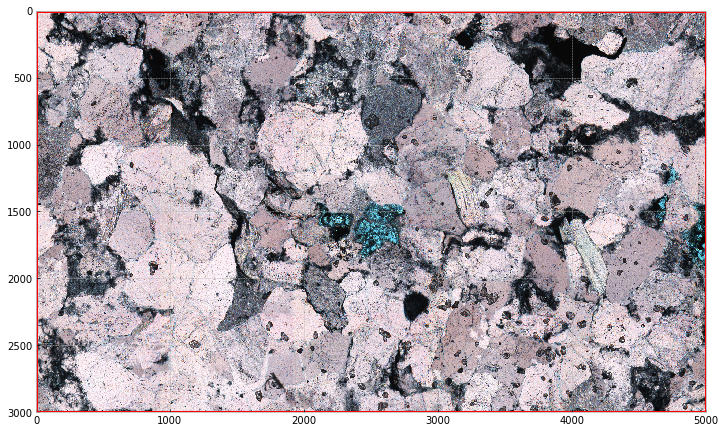

In [7]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(12,10))

# Display the image
ax.imshow(ppol_complete)

# Create a Rectangle patch
rect = patches.Rectangle((sub_y_min,sub_x_min),
                         sub_y_max-sub_y_min,
                         sub_x_max-sub_x_min,
                         linewidth=3,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

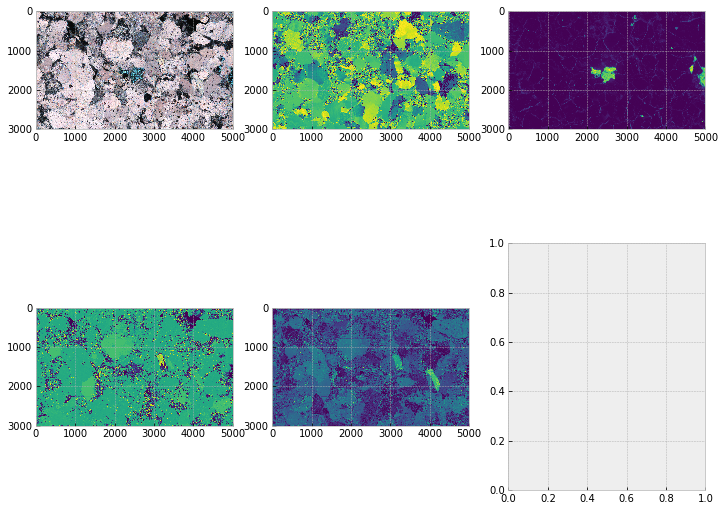

In [8]:
ppol_sub = ppol_complete[sub_x_min:sub_x_max,sub_y_min:sub_y_max]
angle_sub = angle_complete[sub_x_min:sub_x_max,sub_y_min:sub_y_max]
flourescence_sub = flourescence_complete[sub_x_min:sub_x_max,sub_y_min:sub_y_max]
hue_sub = hue_complete[sub_x_min:sub_x_max,sub_y_min:sub_y_max]
saturation_sub = saturation_complete[sub_x_min:sub_x_max,sub_y_min:sub_y_max]

#Creates four polar axes, and accesses them through the returned array
fig, axes = plt.subplots(2, 3, figsize=(12,10))
axes[0, 0].imshow(ppol_sub)
axes[0, 1].imshow(angle_sub)
axes[0, 2].imshow(flourescence_sub)
axes[1, 0].imshow(hue_sub)
axes[1, 1].imshow(saturation_sub)

### Resample/ interpolate

Idea: test several interpolation settings, also potentially reflecting features on multiple scales:

Set size in y-direction, then adjust x to keep aspect ratio correct:

In [9]:
size_y = 100

r = size_y / ppol_sub.shape[1]
dim = (size_y, int(ppol_sub.shape[0] * r))

ppol_interp = cv2.resize(ppol_sub, dim, interpolation = cv2.INTER_AREA)
angle_interp = cv2.resize(angle_sub, dim, interpolation = cv2.INTER_AREA)
flourescence_interp = cv2.resize(flourescence_sub, dim, interpolation = cv2.INTER_AREA)
hue_interp = cv2.resize(hue_sub, dim, interpolation = cv2.INTER_AREA)
saturation_interp = cv2.resize(saturation_sub, dim, interpolation = cv2.INTER_AREA)



### Combine data sets

In [10]:
data = np.stack([ppol_interp[:,:,0], ppol_interp[:,:,1], ppol_interp[:,:,2],
                 # ppol_sub[:,:,0], ppol_sub[:,:,1], ppol_sub[:,:,2],
                 angle_interp, 
                 hue_interp, 
                 saturation_interp, 
                 flourescence_interp])

In [11]:
data = data.swapaxes(0,2)
data.shape

(100, 60, 7)

### Visualizing the data set

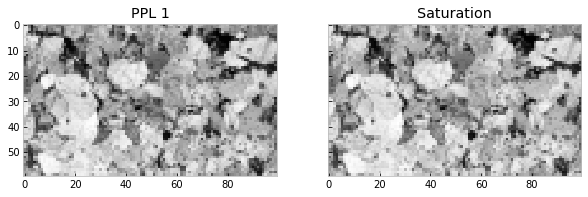

In [12]:
# get min and max of the data
dmin = np.nanmin(data)
dmax = np.nanmax(data)

# create figure
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True)
# plot features onto axes
ax[0].imshow(data[:,:,1].T, cmap="gray")
ax[0].set_title("PPL 1")
ax[1].imshow(data[:,:,2].T, cmap="gray")
ax[1].set_title("Saturation")

for i in range(2):
    ax[i].grid(False)

Replace NaN feature values

In [13]:
data[np.isnan(data)] = -1

### Instantiate classifier

In [14]:
# set number of classes
n_classes = 4
# set initial value for beta
beta_init = 10.

clf = bayseg.BaySeg(data[:,:,:], n_classes, beta_init=beta_init)

In [15]:
data.shape

(100, 60, 7)

### Fit

In [16]:
n_iter = 100
clf.fit(n_iter, beta_jump_length=.1)

100%|██████████| 100/100 [00:09<00:00,  8.83it/s]


### Diagnostics plot

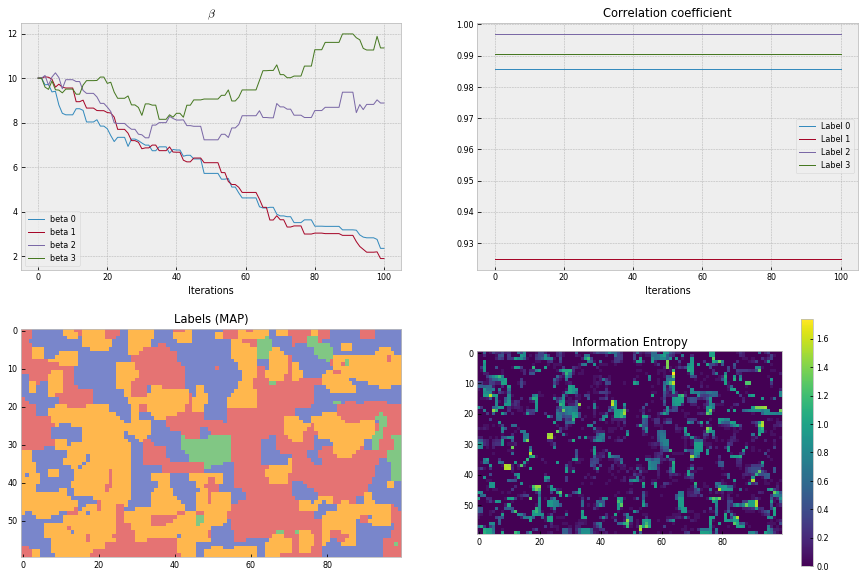

In [17]:
clf.diagnostics_plot(transpose=True)

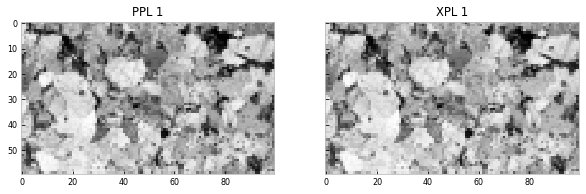

In [18]:
# create figure
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True)
# plot features onto axes
ax[0].imshow(data[:,:,1].T, cmap="gray")
ax[0].set_title("PPL 1")
ax[1].imshow(data[:,:,2].T, cmap="gray")
ax[1].set_title("XPL 1")

for i in range(2):
    ax[i].grid(False)

Run the following code cell and use the interactive slider to move through the segmentation results of different iterations.

In [19]:
tmp = np.argmax(clf.labels_probability, axis=-1)
last_seg = tmp[-1].reshape((data.shape[0],data.shape[1])).T

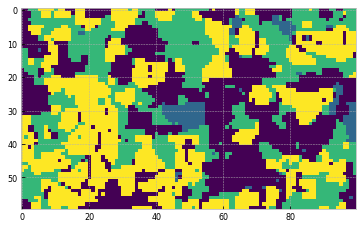

In [20]:
plt.imshow(last_seg)

In [21]:
from skimage.feature import canny
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage.filters import roberts, sobel, scharr, prewitt

/Users/flow/anaconda3/envs/tf/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


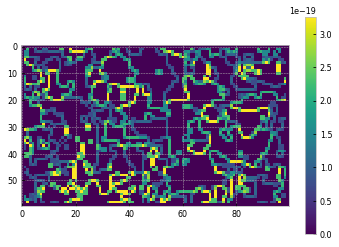

In [22]:
plt.imshow(roberts(last_seg))
plt.colorbar()

In [23]:
img_edges = roberts(last_seg)

In [24]:
type(img_edges)

numpy.ndarray

In [25]:
img_edges[img_edges>0]=1
img_edges[img_edges==0]=np.nan

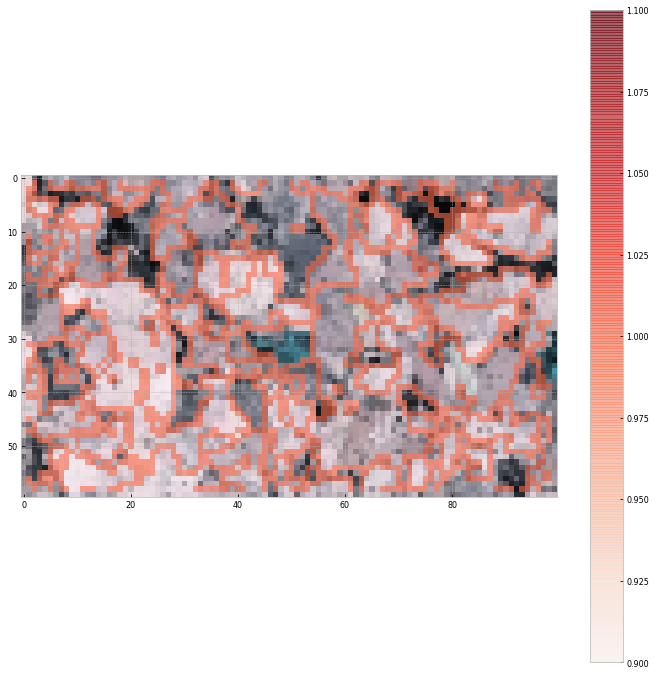

In [26]:
plt.figure(figsize=(12,12))
plt.imshow(ppol_interp)
plt.imshow(img_edges, cmap="Reds", alpha=0.6)
plt.colorbar()

### Segmentation result on all input channels

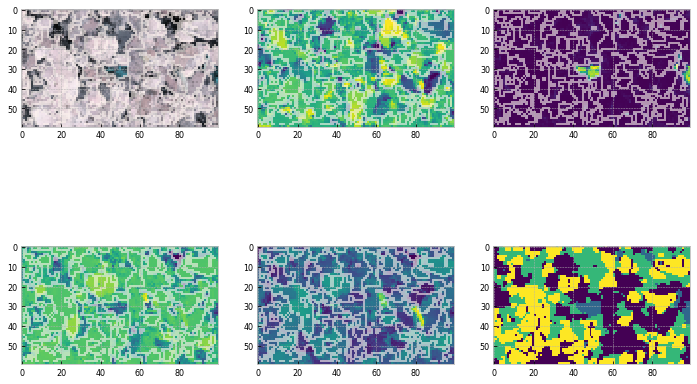

In [38]:
#Creates four polar axes, and accesses them through the returned array
fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes[0, 0].imshow(ppol_interp)
axes[0, 1].imshow(angle_interp)
axes[0, 2].imshow(flourescence_interp)
axes[1, 0].imshow(hue_interp)
axes[1, 1].imshow(saturation_interp)
axes[1, 2].imshow(last_seg)
# add segmentation
seg = roberts(last_seg)
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            break
        axes[i, j].imshow(img_edges, cmap="Reds", alpha=0.6)
        
plt.savefig("../results/segmentation_all_size_%d.png" % size_y)

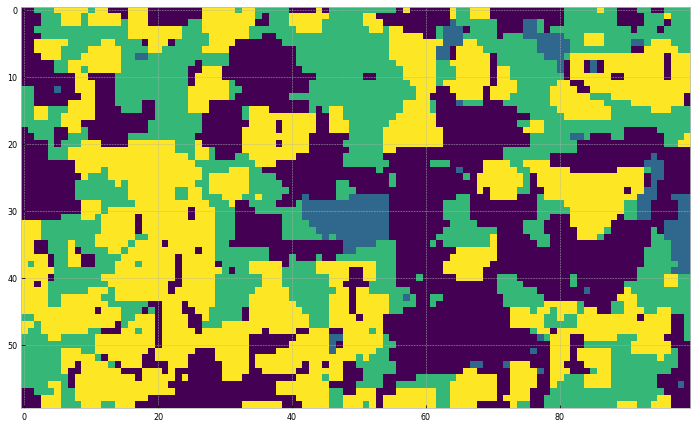

In [39]:
plt.figure(figsize=(12,10))
plt.imshow(last_seg)
plt.savefig("../results/segmentation_size_%d.png" % size_y)

### Compare characteristics of extracted classes

In [29]:
class_id = 0
tmp = last_seg== class_id

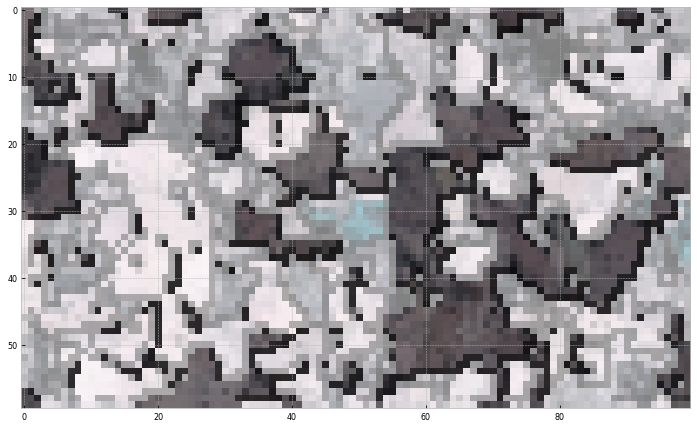

In [30]:
plt.figure(figsize=(12,12))
plt.imshow(ppol_interp) #, cmap="gray")
plt.imshow(img_edges, cmap="gray", alpha=0.6)
plt.imshow(tmp, cmap='gray_r', alpha=0.5)

#### Create mask for single classes

In [31]:
mask3D = np.atleast_3d(tmp)*np.ones_like(ppol_interp)

In [32]:
m_img_col  = np.ma.masked_where( mask3D, ppol_interp)

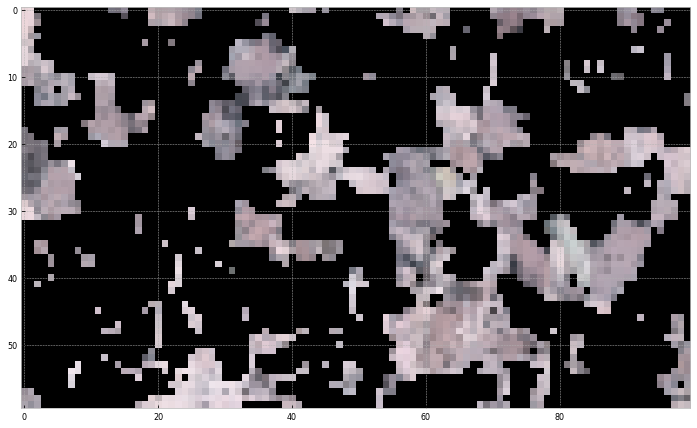

In [33]:
plt.figure(figsize=(12,12))
plt.imshow(mask3D*ppol_interp) #, cmap="gray")

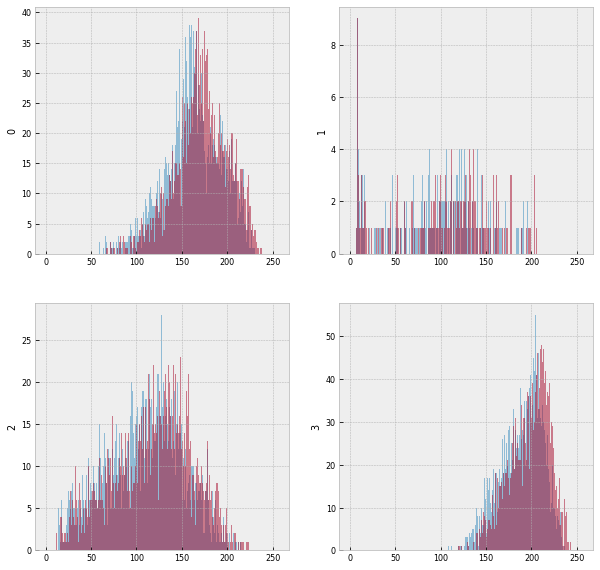

In [34]:
fig, axes = plt.subplots(int(np.ceil(n_classes/2.)), 2, figsize=(10,int(5*np.ceil(n_classes/2.))))

for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i))
    tmp = last_seg==i
    mask3D = np.atleast_3d(tmp)*np.ones_like(ppol_interp)
    ax.hist((mask3D[:,:,1]*ppol_interp[:,:,1]).ravel(), bins=np.arange(1,256,1), alpha=0.5);
    ax.hist((mask3D[:,:,2]*ppol_interp[:,:,2]).ravel(), bins=np.arange(1,256,1), alpha=0.5);

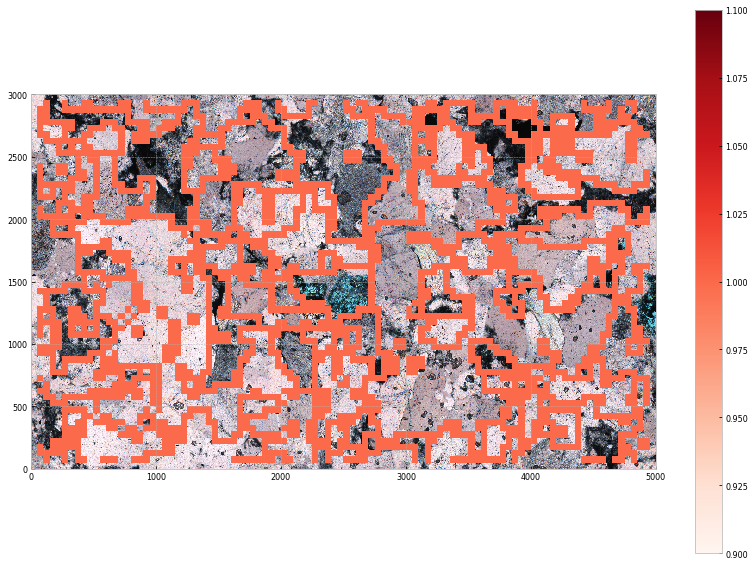

In [35]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(14,10))

extent = (sub_y_min, sub_y_max, sub_x_min, sub_x_max)

# Display the image
ax.imshow(ppol_complete, extent=extent)
im = ax.imshow(img_edges, cmap="Reds", alpha=1.0, extent=extent)
plt.colorbar(im)


# save extracted edges for further use:


In [40]:
import pickle

In [44]:
f = open("../results/last_seg_size_%d.pkl" % size_y, 'wb')
pickle.dump(last_seg, f)
f.close()

### Next ideas:

- Apply on multiple resolutions for entire image (for subgrain structures)
- Calculate BIC for cluster number analysis
- Use hierarchical clustering (first segment on low res/ full pic, then only on selected class/ use mask? on higher res image)

In [ ]:
img_edges_500 = img_edges